AR non-anomaly composites of different variables using different cEOF tests (e.g. DJF, MAM, DJF-MAM). 

Creates significant differences plots for IVT and upper level plots. (e.g. El Nino vs Neutral conditions for each AR type)


## Imports

In [1]:
# Standard Python modules
import os, sys
import yaml
from pathlib import Path
import numpy as np
import pandas as pd
import xarray as xr
# matplotlib
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1 import AxesGrid
from matplotlib import rcParams
from matplotlib.colors import ListedColormap
# plot styles/formatting
import seaborn as sns
import cmocean.cm as cmo
import cmocean
# cartopy
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes

# Extra 
from scipy.ndimage import gaussian_filter    # smoothing contour lines
import metpy.calc as mpcalc
from metpy.units import units
from IPython.display import Image, display

# import personal modules
# Path to modules
sys.path.append('../modules')
# Import my modules
from plotter import draw_basemap, add_subregion_boxes, make_cmap
import nclcmaps as nclc
from timeseries import persistence, select_months, create_list_all_dates
from teleconnections import build_teleconnection_df, mjo_index
from statistical_tests import xr_zscore_diff_mean
from ar_funcs import ar_daily_df

In [2]:
# Set up paths

path_to_data = '/home/nash/DATA/data/'                            # project data -- read only
path_to_out  = '/home/nash/DATA/repositories/AR_types/out/'       # output files (numerical results, intermediate datafiles) -- read & write
path_to_figs = '/home/nash/DATA/repositories/AR_types/figs/'      # figures


In [3]:
# Set a default font for all matplotlib text 
rcParams['font.family'] = 'sans-serif'   # font family = 'sans-serif'
rcParams['font.sans-serif'] = 'Arial'    # default sans-serif font = 'Arial'


## Data

In [4]:
# choose season
ssn = 'djfmam'
ceofid = 'IVT'
neofs = 2 # choose number of eofs
nk = 3 # choose number of clusters

out_path = path_to_out + ceofid + '/' + ssn + '/' + 'neof' + str(neofs) + '/k' + str(nk) + '/'
fig_path = path_to_figs + ceofid + '/' + ssn + '/'+ 'neof' + str(neofs) + '/k' + str(nk) + '/'

In [5]:
# import configuration file for plot dictionary
yaml_doc = '../data/plt_config.yml'

config = yaml.load(open(yaml_doc), Loader=yaml.SafeLoader)
#select dictionaries - choose var, anom/nanom, and season
# upper_ precip_ ivt_ and non_anom anom
plot_dict_upper = config['upper_diff']
plot_dict_ivt = config['ivt_diff']
plot_dict_prec = config['precip_diff']
plot_dict_iwv = config['iwv_diff']
plot_dict_500 = config['lower_diff']

plot_dicts = [plot_dict_upper, plot_dict_500, plot_dict_ivt, plot_dict_prec]

# djf_dict mam_dict djfmam_dict
ar_dict = config[ssn]

### AR days and Climate Indices

In [6]:
outpath = path_to_out + ceofid + '/' + ssn + '/' + 'neof' + str(neofs) + '/k' + str(nk) + '/'
start_date = '1979-12-01'
end_date = '2019-05-31'

# climate index df
tele = build_teleconnection_df('daily', 'COND', start_date, end_date)
mjo = mjo_index('daily', ar_dict['start_date'], ar_dict['end_date'])
tele['MJO'] = mjo['COND']
df_index = select_months(tele, 12, 5)

df = ar_daily_df(ssn, nk, outpath)
# combine ar df with tele df
# join indices with AR count
new_df = df.join(df_index)
new_df

,AR_CAT1,AR_CAT2,AR_CAT3,AR_ALL,AR_CAT,AO,PDO,ENSO,SH,MJO
date,,,,,,,,,,
1979-12-01 09:00:00,0.0,1.0,0.0,1.0,2,1,0,0,0,1
1979-12-02 09:00:00,1.0,0.0,0.0,1.0,1,1,0,0,0,1
1979-12-03 09:00:00,0.0,0.0,0.0,0.0,0,1,0,0,0,1
1979-12-04 09:00:00,0.0,0.0,0.0,0.0,0,1,0,0,0,1
1979-12-05 09:00:00,0.0,0.0,0.0,0.0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...
2019-05-27 09:00:00,0.0,0.0,0.0,0.0,0,0,0,1,1,1
2019-05-28 09:00:00,0.0,0.0,0.0,0.0,0,-1,0,1,1,1
2019-05-29 09:00:00,1.0,0.0,0.0,1.0,1,-1,0,1,1,1


In [7]:
## correlation matrix
new_df.corr()

,AR_CAT1,AR_CAT2,AR_CAT3,AR_ALL,AR_CAT,AO,PDO,ENSO,SH,MJO
AR_CAT1,1.000000,-0.135761,-0.179047,0.417618,0.017356,0.029858,-0.023258,0.031557,-0.023554,0.013951
AR_CAT2,-0.135761,1.000000,-0.182463,0.425585,0.325411,0.062105,0.023990,0.043952,-0.026814,-0.016686
AR_CAT3,-0.179047,-0.182463,1.000000,0.561280,0.835005,-0.009473,0.051142,0.010688,0.001029,-0.008669
AR_ALL,0.417618,0.425585,0.561280,1.000000,0.892192,0.052804,0.041512,0.058025,-0.032172,-0.008852
AR_CAT,0.017356,0.325411,0.835005,0.892192,1.000000,0.032237,0.056961,0.042660,-0.019763,-0.013811
AO,0.029858,0.062105,-0.009473,0.052804,0.032237,1.000000,-0.169020,-0.025015,-0.101567,0.005215
PDO,-0.023258,0.023990,0.051142,0.041512,0.056961,-0.169020,1.000000,0.397739,0.029224,-0.076604
ENSO,0.031557,0.043952,0.010688,0.058025,0.042660,-0.025015,0.397739,1.000000,-0.224652,-0.020668
SH,-0.023554,-0.026814,0.001029,-0.032172,-0.019763,-0.101567,0.029224,-0.224652,1.000000,0.040454
MJO,0.013951,-0.016686,-0.008669,-0.008852,-0.013811,0.005215,-0.076604,-0.020668,0.040454,1.000000


In [8]:
from scipy.stats import pearsonr
import pandas as pd

def calculate_pvalues(df):
    df = df.dropna()._get_numeric_data()
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            pvalues[r][c] = round(pearsonr(df[r], df[c])[1], 4)
    return pvalues

calculate_pvalues(new_df)

,AR_CAT1,AR_CAT2,AR_CAT3,AR_ALL,AR_CAT,AO,PDO,ENSO,SH,MJO
AR_CAT1,0.0,0.0,0.0,0.0,0.1384,0.0108,0.0471,0.007,0.0443,0.2336
AR_CAT2,0.0,0.0,0.0,0.0,0.0,0.0,0.0405,0.0002,0.0221,0.1543
AR_CAT3,0.0,0.0,0.0,0.0,0.0,0.4187,0.0,0.3616,0.93,0.4593
AR_ALL,0.0,0.0,0.0,0.0,0.0,0.0,0.0004,0.0,0.006,0.4498
AR_CAT,0.1384,0.0,0.0,0.0,0.0,0.0059,0.0,0.0003,0.0915,0.2384
AO,0.0108,0.0,0.4187,0.0,0.0059,0.0,0.0,0.0327,0.0,0.6562
PDO,0.0471,0.0405,0.0,0.0004,0.0,0.0,0.0,0.0,0.0126,0.0
ENSO,0.007,0.0002,0.3616,0.0,0.0003,0.0327,0.0,0.0,0.0,0.0776
SH,0.0443,0.0221,0.93,0.006,0.0915,0.0,0.0126,0.0,0.0,0.0006
MJO,0.2336,0.1543,0.4593,0.4498,0.2384,0.6562,0.0,0.0776,0.0006,0.0


### ERA5 renalysis

In [9]:
rename_dict_upper = {'z': 'H', 
                     'u': 'U250', 
                     'v':'V250', 
                     'q': 'QV',
                     'latitude': 'lat',
                     'longitude': 'lon'}

rename_dict_prec = {'mtpr': 'prec', 
                    'latitude': 'lat',
                    'longitude': 'lon'}

rename_dict_iwv = {'latitude': 'lat',
                    'longitude': 'lon'}

rename_dict_lower = {'z': 'H', 
                     'u': 'U500', 
                     'v':'V500', 
                     'q': 'QV',
                     'latitude': 'lat',
                     'longitude': 'lon'}

rename_dict_ivt = {'p71.162': 'ivte', 
                   'p72.162': 'ivtn', 
                   'latitude': 'lat',
                   'longitude': 'lon'}

In [10]:
def preprocess(ds):
    '''keep only selected lats and lons'''
    if plot_dict['name'] == 'huv250':
        subset = ds.sel(latitude=slice(latmax, latmin), longitude=slice(lonmin, lonmax), level=plot_dict['lev'])
        subset = subset.rename(rename_dict_upper)
        subset = subset.drop(['QV'])
    if plot_dict['name'] == 'prec':
        subset = ds.sel(latitude=slice(latmax, latmin), longitude=slice(lonmin, lonmax))
        subset = subset.rename(rename_dict_prec)
    if plot_dict['name'] == 'huv500':
        subset = ds.sel(latitude=slice(latmax, latmin), longitude=slice(lonmin, lonmax), level=plot_dict['lev'])
        subset = subset.rename(rename_dict_lower)
        subset = subset.drop(['QV', 'H'])
    if plot_dict['name'] == 'iwv':
        subset = ds.sel(latitude=slice(latmax, latmin), longitude=slice(lonmin, lonmax))
        subset = subset.rename(rename_dict_iwv)
        subset = subset.drop(['tcrw', 'tcsw', 'tcw'])
    if plot_dict['name'] == 'ivt':
        subset = ds.sel(latitude=slice(latmax, latmin), longitude=slice(lonmin, lonmax))
        subset = subset.rename(rename_dict_ivt)
        
    return subset

f = []

# Select lat/lon grid bbox [latmin, latmax, lonmin, lonmax]
# bbox = [20, 120, 5, 55] # zoomed out
bbox = [20, 110, 0, 55] # same as synoptic composites
lonmin, lonmax, latmin, latmax = bbox

    
for p, plot_dict in enumerate(plot_dicts):

    # # open data  
    f.append(xr.open_mfdataset(path_to_data + plot_dict['fname'] , preprocess=preprocess, combine='by_coords'))

ds = xr.merge(f[:3], compat='override')
print('ds size in GB {:0.2f}\n'.format(ds.nbytes / 1e9))
# f[0]['H'] = f[0]['H']/(9.80665), # convert to geopotential height (m)
# f[1]['prec'] = f[1]['prec']*86400 # convert to mm day-1



ds size in GB 16.85



In [11]:
# import precipitation averages for AR Types
# fname = path_to_out+'precip_{0}_{1}_eof{2}_k{3}.nc'.format(ssn, ceofid, str(neofs), str(nk)) # non-anomaly
fname = path_to_out+'precip_anom_{0}_{1}_eof{2}_k{3}.nc'.format(ssn, ceofid, str(neofs), str(nk)) # anomaly
precipitation = xr.open_dataset(fname)
precipitation

<xarray.Dataset>
Dimensions:  (ar_type: 3, lat: 221, lon: 361)
Coordinates:
  * lon      (lon) float32 20.0 20.25 20.5 20.75 ... 109.25 109.5 109.75 110.0
  * lat      (lat) float32 55.0 54.75 54.5 54.25 54.0 ... 1.0 0.75 0.5 0.25 0.0
Dimensions without coordinates: ar_type
Data variables:
    prec     (ar_type, lat, lon) float64 ...

### Combine with data

In [12]:
%%time
df = new_df
ds_lst = [ds, f[3]]
for i, ds in enumerate(ds_lst):
    # Trim date range
    idx = slice(ar_dict['start_date'], ar_dict['end_date'])
    ds = ds.sel(time=idx)
    
    # Select months
    if ar_dict['mon_s'] > ar_dict['mon_e']:
        idx = (ds.time.dt.month >= ar_dict['mon_s']) | (ds.time.dt.month <= ar_dict['mon_e'])
    else:
        idx = (ds.time.dt.month >= ar_dict['mon_s']) & (ds.time.dt.month <= ar_dict['mon_e'])
    ds = ds.sel(time=idx)
    
    # Combine AR Cat data w/ reanalysis data
    # Add ar time series to the ERA dataset
    cols = ['AR_CAT', 'AO', 'PDO', 'ENSO', 'SH', 'MJO']
    
    for k, col in enumerate(cols):
        ds[col] = ('time', df[col])

    ds = ds.set_coords(tuple(cols))
    
    # select only AR days
    idx = (ds.AR_CAT > 0)
    ds = ds.sel(time=idx)
    print('ds size in GB {:0.2f}\n'.format(ds.nbytes / 1e9))
    ds = ds.load()
    ds_lst[i] = ds

ds size in GB 3.55

ds size in GB 2.02

CPU times: user 22.5 s, sys: 4min 20s, total: 4min 42s
Wall time: 15min 45s


In [13]:
## calculate 500 hPa wind speed and IVT
ds = ds_lst[0]
ds = ds.assign(wspd=lambda ds: np.sqrt(ds.U500**2 + ds.V500**2))
ds = ds.assign(ivt=lambda ds: np.sqrt(ds.ivte**2 + ds.ivtn**2))
ds_lst[0] = ds
ds_lst[0]

<xarray.Dataset>
Dimensions:    (lat: 111, lon: 181, time: 3157)
Coordinates:
  * lat        (lat) float32 55.0 54.5 54.0 53.5 53.0 ... 2.0 1.5 1.0 0.5 0.0
  * lon        (lon) float32 20.0 20.5 21.0 21.5 ... 108.5 109.0 109.5 110.0
    level      float64 250.0
  * time       (time) datetime64[ns] 1979-12-01T09:00:00 ... 2019-05-29T09:00:00
    dayofyear  (time) int64 335 336 342 343 350 351 ... 138 139 141 144 145 149
    AR_CAT     (time) int64 2 1 2 1 1 3 1 1 1 3 2 1 ... 3 3 3 3 1 1 1 1 1 3 3 1
    AO         (time) int64 1 1 1 1 -1 -1 1 1 0 0 ... -1 -1 -1 -1 -1 -1 0 0 -1
    PDO        (time) int64 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0
    ENSO       (time) int64 0 0 0 0 0 0 0 0 0 0 0 0 ... 1 1 1 1 1 1 1 1 1 1 1 1
    SH         (time) int64 0 0 0 0 0 0 0 0 0 0 0 0 ... 1 1 1 1 1 1 1 1 1 1 1 1
    MJO        (time) int64 1 1 1 1 1 1 1 1 -1 -1 -1 ... 1 1 1 1 1 1 1 1 1 1 1
Data variables:
    H          (time, lat, lon) float64 -115.0 -134.0 -153.6 ... 309.5 297.6
    U250       (time, lat, lon) float64 4.367 4.47 4.64 ... 7.818 8.909 10.27
    V250       (time, lat, lon) float64 -6.328 -6.417 -6.505 ... 1.186 1.068
    U500       (time, lat, lon) float64 4.103 3.43 3.311 ... -0.346 -0.2971
    V500       (time, lat, lon) float64 -4.713 -4.793 -5.012 ... -2.009 -1.825
    ivtn       (time, lat, lon) float64 -88.99 -84.69 -81.41 ... -82.44 -72.15
    ivte       (time, lat, lon) float64 127.8 117.7 108.3 ... -163.0 -165.7
    wspd       (time, lat, lon) float64 6.249 5.894 6.007 ... 2.113 2.038 1.849
    ivt        (time, lat, lon) float64 155.7 145.0 135.5 ... 200.4 182.7 180.7

### Compute AR Composites

In [14]:
%%time
# Compare condition (e.g. Type 1 ARs during El Nino) to DJFMAM anomalies
artype_lst = [1, 2, 3]*12
cli_lst = ['ENSO']*3 + ['AO']*3 + ['SH']*3 + ['MJO']*3
cond1= 1
cond2_lst = [-1]*9 + [0]*3

com_diff = []
com_pval = []
mjo_diff = []
mjo_pval = []


for m, ds_nm in enumerate(ds_lst):
    ds = ds_nm
    for k, (cli, ar_type, cond2) in enumerate(zip(cli_lst,  artype_lst, cond2_lst)):
        print(cli, ar_type, cond1, cond2)
        idx = (ds[cli] == cond1) & (ds['AR_CAT'] == ar_type)
        data1 = ds.sel(time=idx)
        idx = (ds[cli] == cond2) & (ds['AR_CAT'] == ar_type)
        data2 = ds.sel(time=idx)

        diff, pval = xr_zscore_diff_mean(data1, data2)

        com_diff.append(diff)
        com_pval.append(pval)

ENSO 1 1 -1
ENSO 2 1 -1
ENSO 3 1 -1
AO 1 1 -1
AO 2 1 -1
AO 3 1 -1
SH 1 1 -1
SH 2 1 -1
SH 3 1 -1
MJO 1 1 0
MJO 2 1 0
MJO 3 1 0
ENSO 1 1 -1
ENSO 2 1 -1
ENSO 3 1 -1
AO 1 1 -1
AO 2 1 -1
AO 3 1 -1
SH 1 1 -1
SH 2 1 -1
SH 3 1 -1
MJO 1 1 0
MJO 2 1 0
MJO 3 1 0
CPU times: user 1min 24s, sys: 34.3 s, total: 1min 58s
Wall time: 1min 59s


In [15]:
len(com_diff)

24

### Figures

In [16]:
plot_names = ['ENSO', 'AO', 'SH', 'MJO']
a=3
b=6
c=9
d=12
e=15
f=18
g=21

plot_ds = [com_diff[:a], com_diff[a:b], com_diff[b:c], com_diff[c:d]]
pval_ds = [com_pval[:a], com_pval[a:b], com_pval[b:c], com_pval[c:d]]

plot_prec = [com_diff[d:e], com_diff[e:f], com_diff[f:g], com_diff[g:]]
pval_prec = [com_pval[d:e], com_pval[e:f], com_pval[f:g], com_pval[g:]]

### Common Plot Properties

In [17]:
# Set seaborn plot style
sns.set()
sns.set_style("ticks", {'patch.force_edgecolor':False})

# Set projections
datacrs = ccrs.PlateCarree()   # data/source
mapcrs = ccrs.PlateCarree()    # map/destination

# Set tick/grid locations
dx = np.arange(lonmin,lonmax+10,10)
dy = np.arange(latmin,latmax+10,10)

# subregion info 
# [ymin, xmin]
sr_xy = [[65, 30], [75, 25], [85, 20]]
# width of subregion
sr_width = [10, 10, 10]
# height of subregion
sr_height = [10, 10, 10]

# hack for tick labels
share_bottom = [False, False, True]
# column 1 lats
share_right1 = [False, False, False]
share_left1 = [False, False, False]
# column 2 lats
share_right2 = [False, False, False]
share_left2 = [True, True, True]
# column 3 lats
share_right3= [True, True, True]
share_left3 = [False, False, False]


### Composite Plots

ENSO


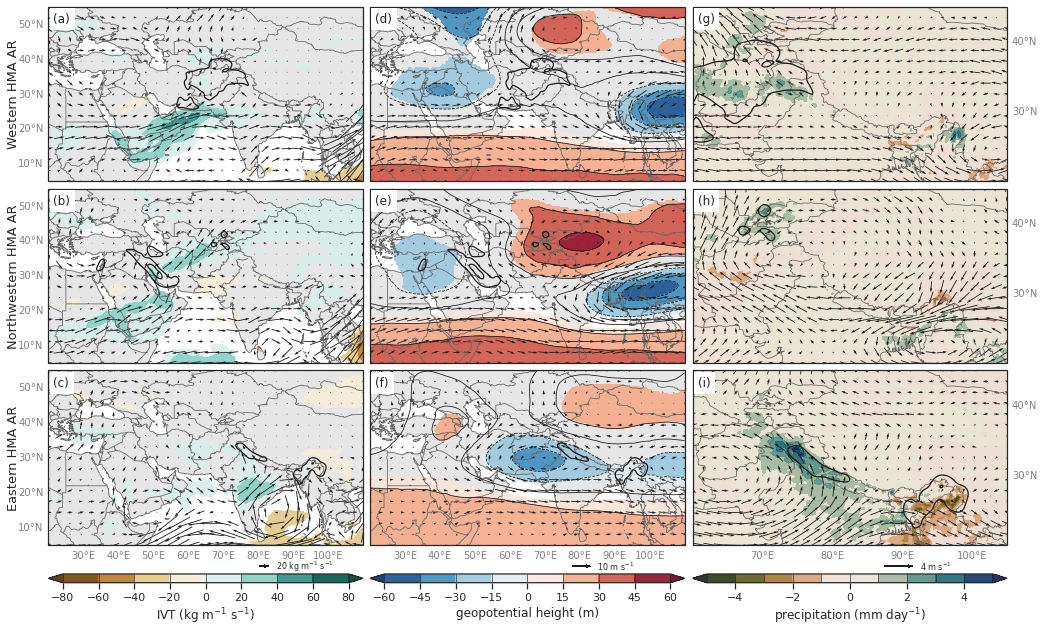

AO


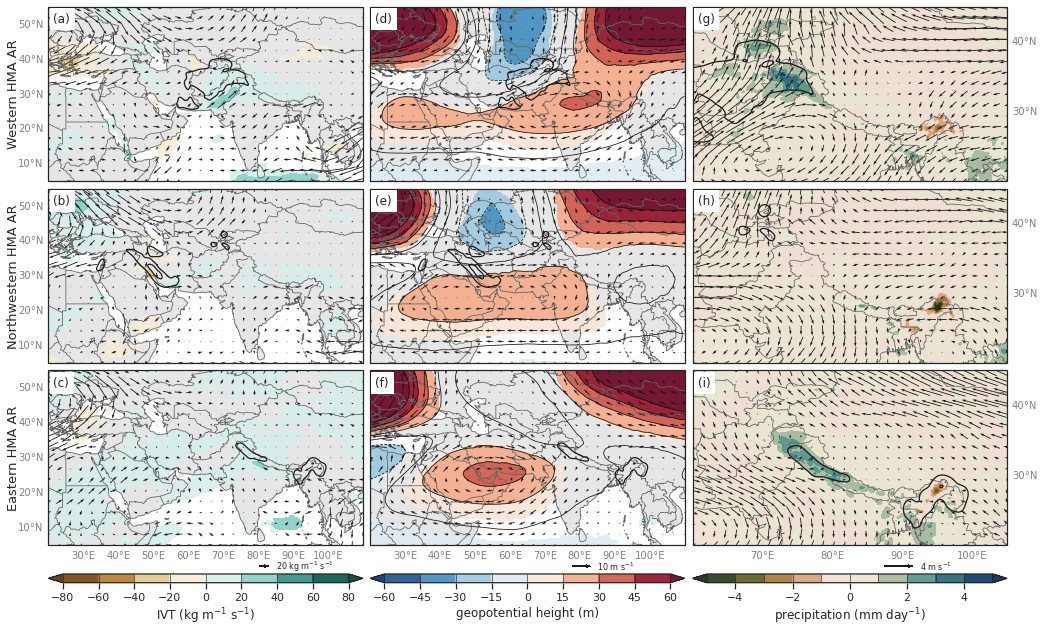

SH


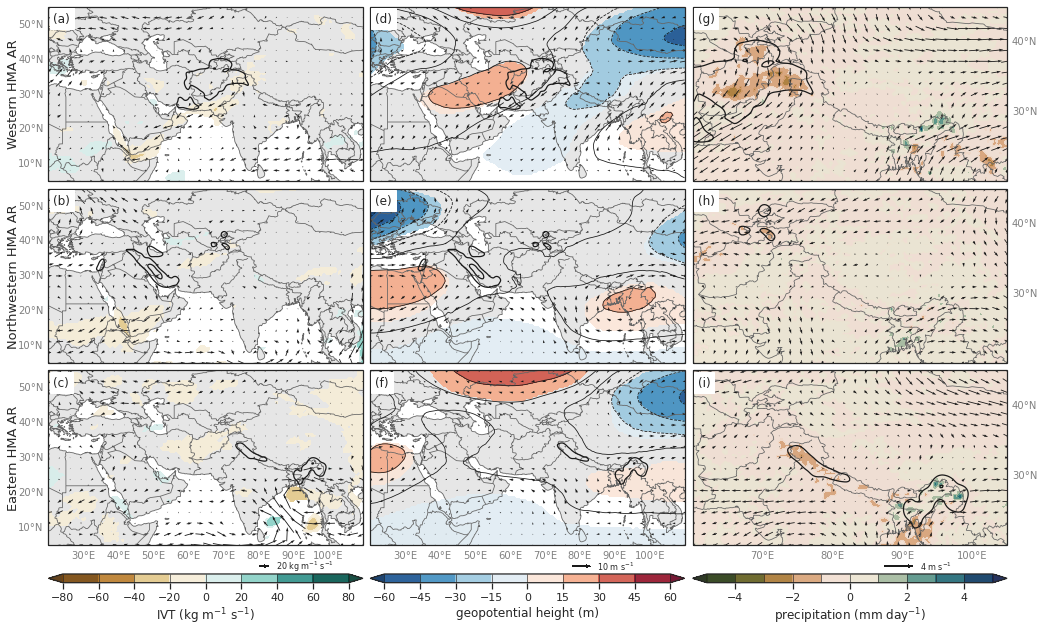

MJO


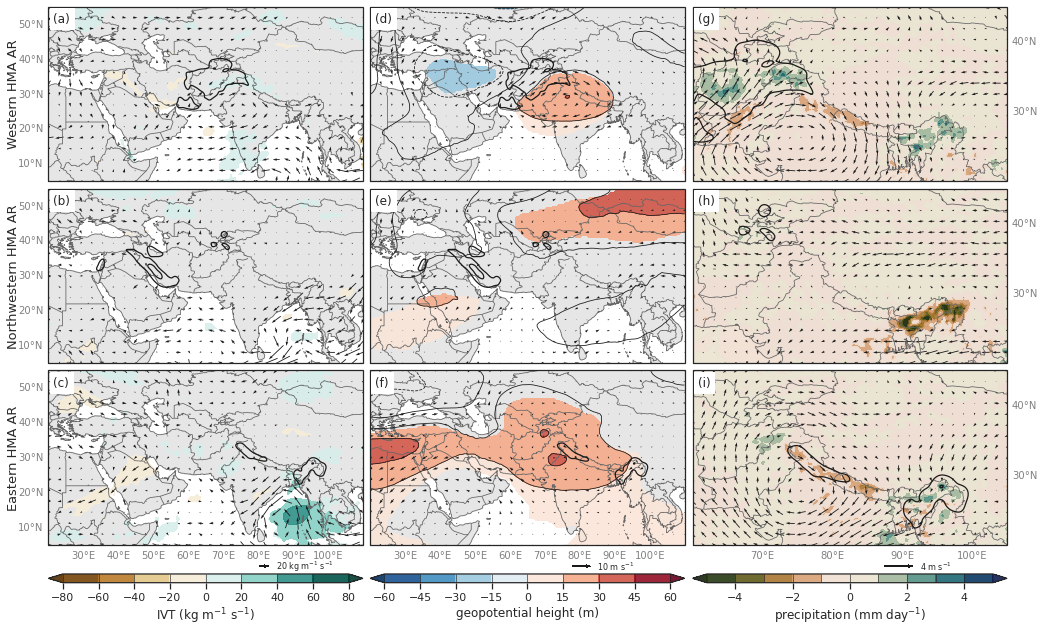

In [19]:
for i, cliindex in enumerate(plot_names):
    print(cliindex)
    filepath = fig_path + 'composite_diff_' + cliindex + '.png'
    nrows = nk
    ncols = 2
    sig_level = 0.05
    artype_lst = [1, 2, 3]
    row_lbl = ['Western HMA AR', 'Northwestern HMA AR', 'Eastern HMA AR']
    col_lbl1 = ['(a)', '(b)', '(c)']
    col_lbl2 = ['(d)', '(e)', '(f)']
    col_lbl3 = ['(g)', '(h)', '(i)']
    ext1 = [20, 110, 5, 55]
    ext2 = [60, 105, 20, 45]
    xpt = 5
    ypt = 159

    # Create figure
    fig = plt.figure(figsize=(15, 10))

    # Set up Axes Grid
    axes_class = (GeoAxes,dict(map_projection=mapcrs))
    axgr = AxesGrid(fig, [0.1, 0.1, 0.66, 0.8], axes_class=axes_class,
                    nrows_ncols=(nrows, ncols), axes_pad = 0.1,
                    cbar_location='bottom', cbar_mode='edge',
                    cbar_pad=0.4, cbar_size='5%',label_mode='',
                    direction='column',
                    aspect=True,
                    share_all = False)

    axgr2 = AxesGrid(fig, [0.7125, 0.1, 0.33, 0.8], axes_class=axes_class,
                    nrows_ncols=(nrows, 1), axes_pad = 0.1,
                    cbar_location='bottom', cbar_mode='edge',
                    cbar_pad=0.4, cbar_size='5%',label_mode='',
                    direction='column',
                    aspect=True,
                    share_all = False)

    ###############################
    ########## IVT PLOTS ##########
    ###############################
    for k, (ax, ar_type) in enumerate(zip(axgr[0:nrows], artype_lst)):
        data = plot_ds[i][k]
        pval = pval_ds[i][k]
        plot_dict = plot_dict_ivt
        # lat/lon arrays
        lats = data.lat.values
        lons = data.lon.values    
        ax = draw_basemap(ax, extent=ext1, xticks=dx, yticks=dy,
                          left_lats=share_left2[k], right_lats=share_right2[k], bottom_lons=share_bottom[k])

        uvec = data.ivte.values
        vvec = data.ivtn.values
        ivt = data.ivt.values
        ivt_mask = data.ivt.where((pval.ivt <= sig_level)).values
    

       # Contour Filled (significant)                           
        cflevs =  np.arange(plot_dict['cflevs'][0], plot_dict['cflevs'][1], plot_dict['cflevs'][2])
        cf = ax.contourf(lons, lats, ivt_mask, transform=datacrs,
                         levels=cflevs, cmap=plot_dict['cmap'], alpha=0.9, extend='both') 

        # Wind barbs / vectors
        Q = ax.quiver(lons, lats, uvec, vvec, transform=datacrs, 
                      color='k', regrid_shape=17, pivot='middle',
                      angles='xy', scale_units='xy', scale=plot_dict['quiver_scale'], units='xy')


        # Contour Lines (Precip conditions)
        prec = precipitation.prec.isel(ar_type=k)
        clevs = np.arange(2, 10, 4)
        prec_sm = gaussian_filter(prec.values, sigma=2.0)
        cs = ax.contour(prec.lon, prec.lat, prec_sm, transform=datacrs,
                        levels=clevs, colors='k', linewidths=1.25)
        
        # subtitles
#         ax.set_title(col_lbl1[k], loc='left',fontsize=13)
        ax.annotate(col_lbl1[k], (xpt, ypt), xycoords='axes points', fontsize=12.,
                    backgroundcolor='white')
        # Row labels
        ax.text(-0.09, 0.5, row_lbl[k], va='bottom', ha='center',
                rotation='vertical', rotation_mode='anchor', fontsize=13,
                transform=ax.transAxes)
        
    # quiver key
    qk = ax.quiverkey(Q, 0.7, -0.12, plot_dict['quiver_key'], plot_dict['quiver_key_lbl'], labelpos='E',
                      coordinates='axes', fontproperties={'size': 8.0})
    # Colorbar (single)
    cb = fig.colorbar(cf, axgr.cbar_axes[0], orientation='horizontal', drawedges=True)
    cb.set_label(plot_dict['cb_label'])

    ##################################
    ########## UPPER PLOTS ###########
    ##################################
    for k, (ax, ar_type) in enumerate(zip(axgr[nrows:nrows+nrows], artype_lst)):
        data = plot_ds[i][k]
        pval = pval_ds[i][k]
        plot_dict = plot_dict_upper
        # lat/lon arrays
        lats = data.lat.values
        lons = data.lon.values    
        ax = draw_basemap(ax, extent=ext1, xticks=dx, yticks=dy,
                          left_lats=share_left1[k], right_lats=share_right1[k], bottom_lons=share_bottom[k])

        uvec = data.U250.values
        vvec = data.V250.values
        hgts = data.H.values/(9.80665) # convert to geopotential height (m)

        uvec_mask = data.U250.where((pval.U250 <= sig_level) | (pval.V250 <= sig_level)).values
        vvec_mask = data.V250.where((pval.U250 <= sig_level) | (pval.V250 <= sig_level)).values
        hgts_mask = data.H.where((pval.H <= sig_level)).values/(9.80665) # convert to geopotential height (m)

       # Contour Filled (hgts significant)                           
        cflevs = clevs = np.arange(-60, 75, 15)
        cf = ax.contourf(lons, lats, hgts_mask, transform=datacrs,
                         levels=cflevs, cmap=plot_dict['cmap'], alpha=0.9, extend='both') 

        # Wind barbs / vectors
        Q = ax.quiver(lons, lats, uvec, vvec, transform=datacrs, 
                      color='k', regrid_shape=17, pivot='middle',
                      angles='xy', scale_units='xy', scale=plot_dict['quiver_scale'], units='xy')

        # Contour Lines (250-hPa Heights ALL)
        clevs = cflevs
        cs = ax.contour(lons, lats, hgts, transform=datacrs,
                        levels=clevs, colors='k', linewidths=0.8)

        # Contour Lines (Precip conditions)
        prec = precipitation.prec.isel(ar_type=k)
        clevs = np.arange(2, 10, 4)
        prec_sm = gaussian_filter(prec.values, sigma=2.0)
        cs = ax.contour(prec.lon, prec.lat, prec_sm, transform=datacrs,
                        levels=clevs, colors='k', linewidths=1.25)
        # subtitles
#         ax.set_title(col_lbl2[k], loc='left',fontsize=13)
        ax.annotate(col_lbl2[k], (xpt, ypt), xycoords='axes points', fontsize=12.,
                    backgroundcolor='white')
    # quiver key
    qk = ax.quiverkey(Q, 0.7, -0.12, plot_dict['quiver_key'], plot_dict['quiver_key_lbl'], labelpos='E',
                          coordinates='axes', fontproperties={'size': 8.0})
    # Colorbar (single)
    cb = fig.colorbar(cf, axgr.cbar_axes[1], orientation='horizontal', drawedges=True)
    cb.set_label('geopotential height (m)')
    
    #################################################
    ########## PREC and 500HPA WIND PLOTS ###########
    #################################################
    for k, (ax, ar_type) in enumerate(zip(axgr2, artype_lst)):
        data = plot_prec[i][k]
        pval = pval_prec[i][k]
        plot_dict = plot_dict_upper
        # lat/lon arrays
        lats = data.lat.values
        lons = data.lon.values    
        ax = draw_basemap(ax, extent=ext2, xticks=dx, yticks=dy,
                          left_lats=share_left3[k], right_lats=share_right3[k], bottom_lons=share_bottom[k])

        prec = data.prec.values*86400 # convert to mm day-1
        prec_mask = data.prec.where((pval.prec <= sig_level)).values*86400 # convert to mm day-1

        # Contour Filled                           
        cflevs = clevs = np.arange(-5, 6, 1)
        cf = ax.contourf(lons, lats, prec, transform=datacrs,
                         levels=cflevs, cmap=cmo.tarn, alpha=0.9, extend='both') 

        # Contour Lines (Precip conditions)
        prec = precipitation.prec.isel(ar_type=k)
        clevs = np.arange(2, 10, 4)
        prec_sm = gaussian_filter(prec.values, sigma=2.0)
        cs = ax.contour(prec.lon, prec.lat, prec_sm, transform=datacrs,
                        levels=clevs, colors='k', linewidths=1.25)
        
        # 500-hPa Winds (m/s)
        data = plot_ds[i][k]
        pval = pval_ds[i][k]
        plot_dict = plot_dict_500
        lats = data.lat.values
        lons = data.lon.values    
        uwnd = data.U500.values
        vwnd = data.V500.values

        # Wind barbs / vectors
        Q = ax.quiver(lons, lats, uwnd, vwnd, transform=datacrs, 
                      color='k', regrid_shape=17, pivot='middle',
                      angles='xy', scale_units='xy', scale=1, units='xy')
        
        # subtitles
#         ax.set_title(col_lbl3[k], loc='left',fontsize=13)
        ax.annotate(col_lbl3[k], (xpt, ypt), xycoords='axes points', fontsize=12.,
                    backgroundcolor='white')
    # quiver key
    qk = ax.quiverkey(Q, 0.7, -0.12, plot_dict['quiver_key'], plot_dict['quiver_key_lbl'], labelpos='E',
                      coordinates='axes', fontproperties={'size': 8.0})    
    # Colorbar (single)
    cb = fig.colorbar(cf, axgr2.cbar_axes[0], orientation='horizontal', drawedges=True)
    cb.set_label('precipitation (mm day$^{-1}$)')
        
    # Save figure
    plt.savefig(filepath, dpi=300, bbox_inches='tight')

    # Show
    plt.show()
